In [1]:
#############################################################################
## Image augmentation
## All functions take a standard data frame as input
#############################################################################

from nolearn.lasagne import BatchIterator
from skimage import data, img_as_float
from skimage import exposure
#from skimage.filters import gaussian_filter as gaussian
from skimage.filters import gaussian
from skimage.transform import rotate
from scipy.ndimage.interpolation import shift
import pandas as pd
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import pylab as plt

%matplotlib inline

class imageAugmenter(object):

    def __init__(self, num=100, input_data_file='training.csv'):
        # assume input data is the same format as Kaggle provides
        self.input_data_file = input_data_file
        self.input_df = None
        self.X=None
        self.y=None
        self.num = num #number of new images to generate
        
        self.aug_X = []
        self.aug_y = []
        
        self.aug_df = None
        
        print 'Importing original data.'
        self.import_given_dataset()
        
        print 'Generating augmented data.'
        self.make_augmented_images()
        
    def make_augmented_images(self):

        for im_num in range(self.num):
            # Choose one of the augmentations at random
            
            try:
                func_list = [self.contrast_augment, 
                             self.blur_augment, 
                             self.rotate_augment, 
                             self.shift_augment, 
                             self.flip_lr]
                
################====================================################################
#  If you don't want to use any of the particular augmentation types, uncomment and 
#    edit the following to get rid of the ones you don't want:
#
#                func_list = [self.contrast_augment, 
#                             self.blur_augment, 
#                             self.rotate_augment, 
#                             self.shift_augment, 
#                            self.flip_lr]
################====================================################################

                
                # Fetch a random record
                # Flatten image to use augmentations
                this_rec = np.random.choice(range(len(self.X)))
                thisX = self.X[this_rec].flatten()
                thisY = self.y[this_rec]
                
                # Choose a function from the list at random and apply the normal call syntax to it
                X_new, y_new = np.random.choice(func_list)(thisX, thisY)

                self.aug_X.append(X_new)
                self.aug_y.append(y_new*48+48)

            except Exception as e:
                print 'Augmentation error   ', e, '  Skipping this for the next one.'

    
                    
#    def back_to_df(self):
#        
#        for cc in range(len(self.aug_y)):
#            newRec = list(self.y[cc]*48+48)
#            newRec.append(self.X[cc])
#            newRec = pd.Series(newRec,index=df.columns)
#            self.aug_df = self.aug_df.append(newRec, ignore_index=True)
#            print cc
        
    def df_to_csv(self,outFileName):
        for cc in range(len(self.aug_y)):
            newRec = list(self.y[cc]*48+48)
            newRec.append(" ".join([str(int(kk*255)) for kk in list(self.X[cc])]))
            newRec = pd.Series(newRec, index=self.input_df.columns)
            self.aug_df = self.aug_df.append(newRec, ignore_index=True)
            print '\r', cc+1,
    
        oFile = open(outFileName,'w')
        self.aug_df.to_csv(oFile, index=False)
        print '\nNew image set written to ', outFileName
        oFile.close()
        
    def import_given_dataset(self):

        df = read_csv(self.input_data_file)  # load pandas dataframe

        # The Image column has pixel values separated by space; convert
        # the values to numpy arrays:
        df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

        #print(df.count())  # prints the number of values for each column
        df = df.dropna()  # drop all rows that have missing values in them

        X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
        X = X.astype(np.float32)

        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        #X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)

        self.X = X
        self.y = y
        self.input_df = df
        self.aug_df = pd.DataFrame(columns = df.columns)
     
    # Flip left-right ###########################################
    # -- Stolen from Dan Nouri's web page
    def flip_lr(self, Xb, yb, show=False):
        
        flip_indices = [
            (0, 2), (1, 3),
            (4, 8), (5, 9), (6, 10), (7, 11),
            (12, 16), (13, 17), (14, 18), (15, 19),
            (22, 24), (23, 25),
            ]

        image=Xb.reshape(96,96)[:,::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb_flipped = yb.copy()
            yb_flipped[::2] *= -1.0
    
            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in flip_indices:
                yb_flipped[a], yb_flipped[b] = (yb_flipped[b], yb_flipped[a])
                
        if show:
            plt.subplot(1,2,1)
            plot_sample(Xb, yb, plt.gca())
            plt.title('Original')
            
            plt.subplot(1,2,2)
            plot_sample(image, yb_flipped, plt.gca())
            plt.title('LR-Flipped')

            plt.show()
        return image, yb_flipped
        

    

    # linear slide ###########################################
    def shift_augment(self, Xb, yb, amount='random', show=False):
        
        if amount == 'random':
            amount = np.random.randn(2)*10
            
        image = shift(Xb.reshape(96,96), amount, mode='constant')
        yb_shifted = (yb*48.0+48).reshape(15,2)
        yb_shifted[:,0] = yb_shifted[:,0]+amount[1]
        yb_shifted[:,1] = yb_shifted[:,1]+amount[0] #images & coords have opposite axis conventios
        yb_shifted = (yb_shifted.reshape(30,1)-48)/48.0

        if show:
            plt.subplot(1,2,1)
            plot_sample(Xb, yb, plt.gca())
            plt.title('Original')
            
            plt.subplot(1,2,2)
            plot_sample(image, yb_shifted, plt.gca())
            plt.title('Random Shift (X&Y)')

            plt.show()
        
        return image, yb_shifted
    
    # Rotate +/- 10 degrees (around image center)#############
    def rotate_augment(self, Xb, yb, degrees='random', show=False):

        if degrees == 'random':
            degrees = np.random.randn()*30  #normal with sigma=30 degrees
        
        image = Xb.reshape(96,96)
        rotated = rotate(image, degrees, resize=False, mode='constant',preserve_range=True)

        radians = degrees * np.pi / 180
        rotation_matrix = np.array([np.cos(radians), -np.sin(radians), np.sin(radians),  np.cos(radians)])
        rotation_matrix = rotation_matrix.reshape(2,2)

        # Raw points are already centered facepoints around the origin
        # rotate
        rotated_points = np.dot(yb.reshape(15,2),rotation_matrix)

        # return rotated point in raw scale (let the plot_scatter func. rescale them)
        
        if show:
            plt.subplot(1,2,1)
            plot_sample(image, yb,plt.gca())
            plt.title('Original')
            
            plt.subplot(1,2,2)
            plot_sample(rotated,rotate_face_points(yb, degrees),plt.gca())
            plt.title('Random Rotation')
            plt.show()

        return rotated, rotated_points.reshape(30,1)


    # Blur ######################################################
    def blur_augment(self, Xb, yb, sigma = 'random', show=False):
        
        if sigma == 'random':
            sigma = np.random.rand(2)*5
        
        image = Xb.reshape(96,96)
        blury = gaussian(image,sigma)

        if show:
            plt.subplot(1,2,1)
            plt.imshow(image,cmap='gray')
            plt.title('Original')
            
            plt.subplot(1,2,2)
            plt.imshow(blury,cmap='gray')
            plt.title('Random 2-D Gaussian Blur')
            plt.show()

        return blury, yb


    # Make them have crappy contrast ##############################
    def contrast_augment(self, Xb, yb, show=False):

        import pylab as plt

        # get rid of pesky 0-value pixels that hose up the log
        orig_shape = Xb.shape
        
        image = Xb.flatten()
        image = np.array([pixel + 0.0001 if pixel < 1 else pixel for pixel in image])
        # Adjust contrast & rescale to [0,1]
        bright = (np.log(image)+max(abs(np.log(image))))/max(abs(np.log(image)))
        bright = bright.reshape(orig_shape)
        
        dim = np.exp(image)/np.max(np.exp(image))
        dim = dim.reshape(orig_shape)

        if show:
            plt.subplot(1,3,1)
            plt.imshow(image.reshape(96,96),cmap='gray')
            plt.title('Original')

            plt.subplot(1,3,2)
            plt.imshow(bright.reshape(96,96),cmap='gray')
            plt.title('Bright')
            
            plt.subplot(1,3,3)
            plt.imshow(dim.reshape(96,96),cmap='gray')
            plt.title('Dim')
            
            plt.show()

        
        if np.random.choice([0,1]): 
            #print 'Dim'
            return dim, yb
        else:
            #print 'Bright'
            return bright, yb



Using gpu device 0: GRID K520 (CNMeM is disabled, CuDNN not available)
/usr/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
################====================================################################
# Change num to how many augmented images you want
# Change 'testAug.csv' to desired path and file name
################====================================################################

bork = imageAugmenter(num=1600, input_data_file='../Data/training.csv')
print len(bork.aug_X), ' new images created.  Writing to file.'
bork.df_to_csv('../Data/testAug.csv')

Importing original data.
Generating augmented data.


/usr/local/lib64/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib64/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib64/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib64/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
/usr/local/lib64/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.ga

1600  new images created.  Writing to file.
1600 
New image set written to  ../Data/testAug.csv


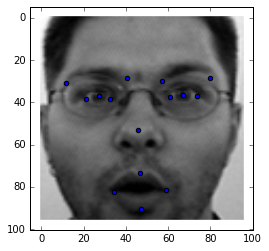

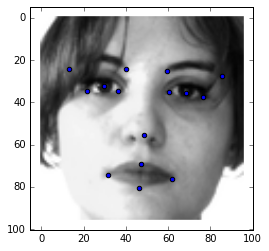

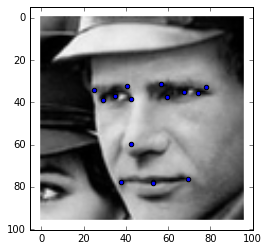

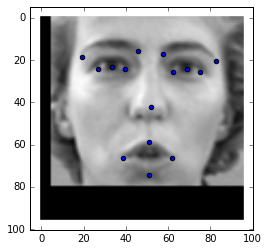

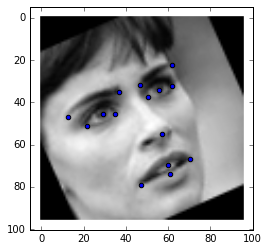

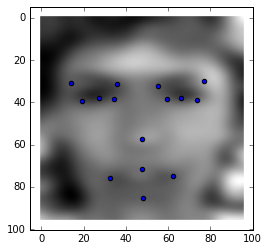

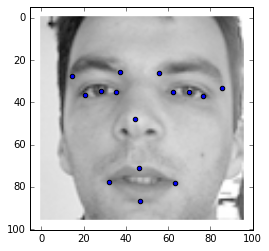

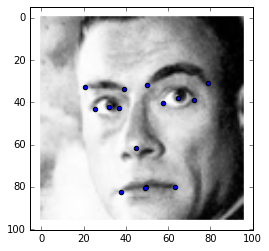

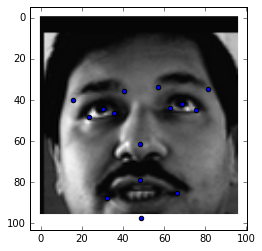

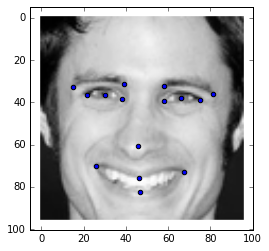

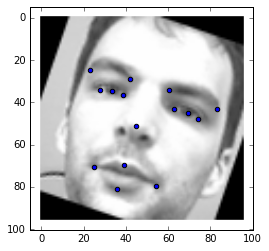

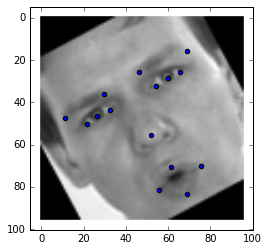

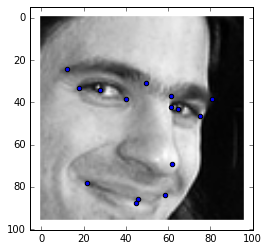

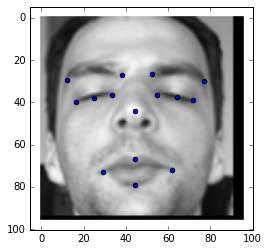

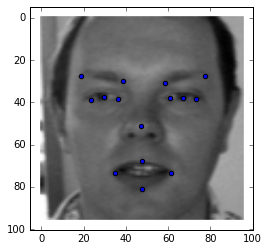

In [3]:
################====================================################################
#  Run this to see what some of the new images look like
################====================================################################

for cc in range(15):
    plt.imshow(bork.aug_X[cc].reshape(96,96),cmap='gray')
    plt.hold('on')
    y = bork.aug_y[cc].reshape(15,2)
    plt.scatter(y[:,0],y[:,1])
    plt.hold('off')
    plt.show()
